<a href="https://colab.research.google.com/github/BhavaniRanjith/Automate-Sentiment-Analysis-of-Textual-Comments-and-Feedback/blob/main/understanding_naive_bayes_for_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes for US Airline Sentiment Analysis

Understanding how to implement Naive Bayes from scratch to predict the sentiment of tweets regarding US Airlines.

In order to predict the sentiment of tweets about US Airlines using Naive Bayes, it's necessary to understand how to implement the algorithm from scratch. This involves training a machine learning model on a labeled dataset of tweets, and using Bayes' theorem to calculate the probability of each tweet belonging to a particular sentiment category. By understanding the underlying mechanics of Naive Bayes, it's possible to create a customized implementation that is tailored to the specific needs of the application. With this knowledge, it becomes possible to accurately predict the sentiment of tweets about US Airlines and gain valuable insights into customer opinion and feedback.

## Import Libraries and Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
%matplotlib inline

import nltk
import numpy as np
import pandas as pd
import re
import string
import os
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


In [ ]:
# Load data
#data_set=pd.DataFrame()
#for file in os.listdir(os.getcwd()):
    #if file.endswith('.asc'):
             #data_set = data_set.append(pd.read_table(file, header=None, delim_whitespace=True))


#data = data_set.to_csv('Tweets.csv',index=False)
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/Tweets.csv')

In [ ]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

## Data Exploration

Analyze the number of tweets per sentiment:

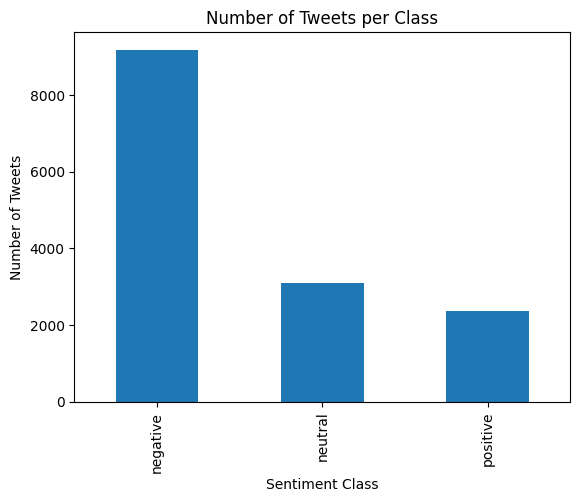

In [ ]:
counts = data['airline_sentiment'].value_counts()
counts.plot(kind='bar')

plt.title('Number of Tweets per Class')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Tweets')
plt.show()

From this plot we can see that the majority of the tweets fall under the negative class. We are going to balance the dataset before training the model because an unbalanced dataset can lead to inaccurate results.

Analyze the number of tweets for each sentiment category for each airline. With this plot it possible to understand how each airline is perceived by customers.

<Figure size 1000x2000 with 0 Axes>

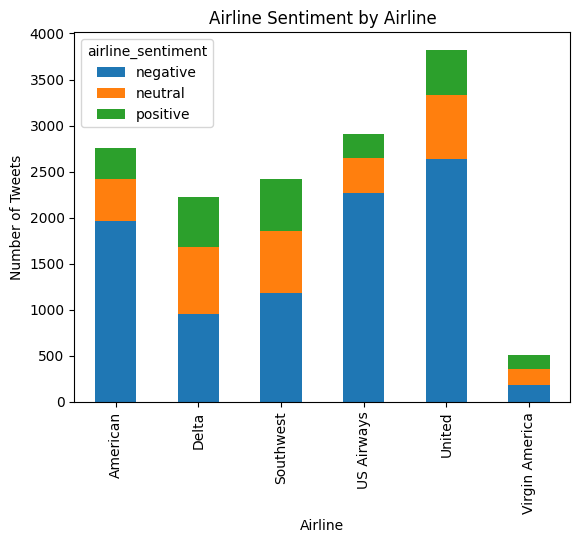

In [ ]:
grouped = data.groupby(['airline', 'airline_sentiment']).size().unstack()

fig = plt.figure(figsize = (10,20))
grouped.plot(kind='bar', stacked=True)
plt.title('Airline Sentiment by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.show()

From this stacked bar chart, we can see the following:

* `United` has the most number of tweets directed at them.
* `Virgin America` has the least number of tweets directed at them.
* A large majority of tweets for `American`, `US Airways`, and `United` have negative sentiment.
* `Virgin America`, `Delta`, and `Southwest` are more balanced when it comes to sentiment of tweets.


Another way to analyze the reasons behind negative sentiment tweets is by using a pie chart. This type of chart can help us identify if the majority of negative tweets are due to a specific reason. By visually representing the data, we can quickly extract useful insights and gain a better understanding of the overall sentiment towards the airline.

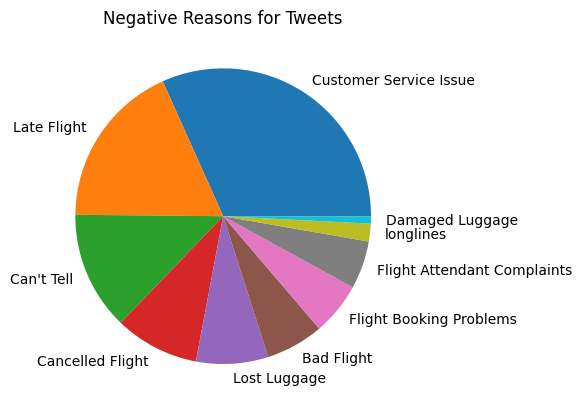

In [ ]:
neg_reason_counts = data['negativereason'].value_counts()

plt.pie(neg_reason_counts, labels=neg_reason_counts.index)
plt.title('Negative Reasons for Tweets')
plt.show()

Based on the information presented in the pie chart, it is evident that the most common reason for negative tweets is related to customer service issues.

## Data Preparation

Balance the dataset and split the data into training and test sets. 80% will be used for training and 20% will be used for testing. For our case we will not be including `neutral` sentiment just to make the task easier and understand Naive Bayes.

In [ ]:
# Separate negative and positive sentiment tweets
neg_data = data[data['airline_sentiment'] == 'negative']
pos_data = data[data['airline_sentiment'] == 'positive']

# Sample an equal number of negative and positive tweets
num_samples = min(len(neg_data), len(pos_data))
neg_data = neg_data.sample(n=num_samples, random_state=42)
pos_data = pos_data.sample(n=num_samples, random_state=42)

# Concatenate the negative and positive sentiment tweets
balanced_data = pd.concat([neg_data, pos_data])

# Shuffle the rows
balanced_data = balanced_data.sample(frac=1, random_state=42)

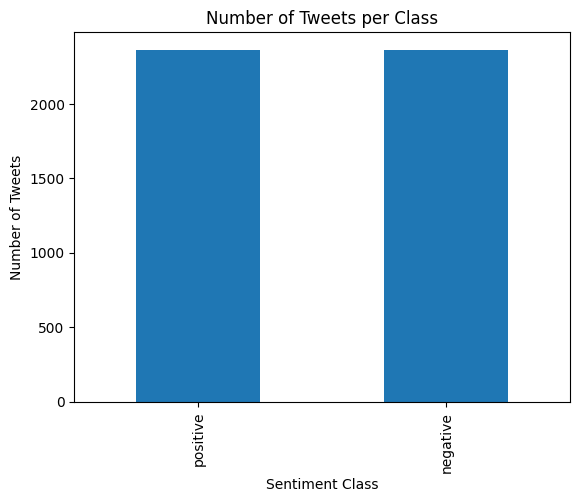

In [ ]:
counts = balanced_data['airline_sentiment'].value_counts()
counts.plot(kind='bar')

plt.title('Number of Tweets per Class')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
print('Number of positive sentiment tweets: {}'.format(len(pos_data)))
print('Number of negative sentiment tweets: {}'.format(len(neg_data)))

Number of positive sentiment tweets: 2363
Number of negative sentiment tweets: 2363


Split the dataset into training and test sets. 80% will be used for training and 20% will be used for testing.

In [ ]:
from sklearn.model_selection import train_test_split

# Split into features and target
X = balanced_data['text'].values.tolist()
y = balanced_data['airline_sentiment'].values.tolist()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state = 42)

In [ ]:
# Map positive to 1 and negative to 0
y_train = [int(sent == 'positive') for sent in y_train]
y_test = [int(sent == 'positive') for sent in y_test]

## Data Preprocessing

The function below takes a tweets as an input and returns a list of cleaned words. The cleaning process includes the following steps:

* Removing stack market tickets like `$AAPL`
* Removing old style retweet text `RT`
* Removing hyperlinks
* Removing hashtags, but keeping the word itself
* Tokenizing the tweet using the `TweetTokenizer` from the `nltk` module
* Removing english stopwords
* Removing punctuation marks
* Stemming each word using `PorterStemmer`

In [ ]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet (str): a string containing a tweet
    Output:
        tweets_clean (list): a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [ ]:
sample_tweet = X_train[0]
print('Tweet before preprocessing: {}'.format(sample_tweet))
print('Tweet after preprocessing: {}'.format(process_tweet(sample_tweet)))

Tweet before preprocessing: @JetBlue Another awesome telephone experience with @JetBlue Thank you, Cory! #Greatcustomerservice✈☺
Tweet after preprocessing: ['anoth', 'awesom', 'telephon', 'experi', 'thank', 'cori', 'greatcustomerservic', '✈', '☺']


## Frequency Dictionary

Build a frequency dictionary for a list of tweets and their corresponding sentiment labels. The function takes two arguments as inputs:

* `tweets`: a list of strings representing tweets.
* `ys`: a numpy array or list of integers representing the sentiment labels of each tweet (either 0 or 1).

The output of the function is a dictionary called `freqs`, where each key is a tuple containing a word and its sentiment label, and the value is the frequency of occurrence of that word with that sentiment in the input tweets.

In [ ]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets (list): a list of tweets
        ys (np.array): an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    Output:
        freqs (Dictionary): a dictionary mapping each (word, sentiment) pair to its frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [ ]:
freqs = build_freqs(X_train, y_train)

## Naive Bayes

Naive Bayes is a probabilistic machine learning algorithm used for classification tasks. It assumes that the features are conditionally independent and uses Bayes' theorem to calculate the posterior probability of each class given the observed features. The class with the highest posterior probability is chosen as the predicted class label for the input.

The equation for Naive Bayes is:

$$P(y | x) = \frac{ P(x | y)  P(y) }{P(x)}$$


## Train Naive Bayes

Here are the steps required to train a Naive Bayes Classifier from scratch:

* Identify the number of classes we have. For our example it is 2.
* Create a probability for each class. $P(T_{pos})$ is the probability that the tweet is positive and $P(T_{neg})$ is the probability that the tweet is negative

These values can be obtained with the following formulas:

$$P(T_{pos}) = \frac{T_{pos}}{T}$$
$$P(T_{neg}) = \frac{T_{neg}}{T}$$

Where $T$ is the total number of tweets and $T_{pos}$ and $T_{neg}$ are the total number of positive tweets and the total number of negative tweets respectively.

In [ ]:
# Calculate the number of tweets, the number of positive tweets, the number of negative tweets
T = len(X_train)
T_pos = y_train.count(1)
T_neg = y_train.count(0)

print('Total number of tweets: {}'.format(T))
print('Number of positive tweets: {}'.format(T_pos))
print('Number of negative tweets: {}'.format(T_neg))

Total number of tweets: 3780
Number of positive tweets: 1877
Number of negative tweets: 1903


In [ ]:
# Calculate the probabilities for each class
Prob_T_pos = T_pos/T
Prob_T_neg = T_neg/T

print('Probability of positive class: {}'.format(Prob_T_pos))
print('Probability of negative class: {}'.format(Prob_T_neg))

Probability of positive class: 0.49656084656084654
Probability of negative class: 0.5034391534391535


#### Prior and Logprior

The underlying probability in the target population of a tweet being positive or negative is represented by the prior probability. Essentially, if we were to randomly select a tweet from the population set without any prior knowledge, what would be the probability of it being positive versus negative? This probability is referred to as the "prior".

The prior is the ratio of probabilites

$$\frac{P(T_{pos})}{P(T_{neg})}$$

We take the log of the prior to rescale it. This is called the logprior.

$$logprior = log{\frac{P(T_{pos})}{P(T_{neg})}}$$

#### Positive and Negative Probability of a Word

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}$$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}$$

* Where $V$ is the number of unique words that appear in `freqs`
* $N_{pos}$ and $N_{neg}$ are the total number of positive and negative words for all tweets respectively

In [ ]:
# Calculate the number of unique words V
vocab = [key[0] for key in freqs.keys()]
V = len(set(vocab))

print('Number of unique words: {}'.format(V))

Number of unique words: 5155


In [ ]:
# Calculate N_pos, N_neg
N_pos = 0
N_neg = 0

for pair in freqs.keys():
    # if label is positive
    if pair[1] > 0:
        N_pos += freqs[pair]
    # if label is negative
    else:
        N_neg += freqs[pair]

print("Number of positive words for all tweets: {}".format(N_pos))
print("Number of negative words for all tweets: {}".format(N_neg))

Number of positive words for all tweets: 14598
Number of negative words for all tweets: 19552


In [ ]:
# Calculation for positive and negative probability of a word. We will do it for the first word in the vocab
print('First Word in vocab: {}'.format(vocab[0]))

# get positive and negative frequency of word
freq_pos = freqs.get((vocab[0],1), 0)
freq_neg = freqs.get((vocab[0],0), 0)

print('Positive frequency of {} is: {}'.format(vocab[0], freq_pos))
print('Negative frequency of {} is: {}'.format(vocab[0], freq_neg))

# calculate the probability that the word is positive and negative
p_w_pos = (freq_pos + 1)/(N_pos + V)
p_w_neg = (freq_neg + 1)/(N_neg + V)

print("The probability that the word: {} is positive is: {}".format(vocab[0], p_w_pos))
print("The probability that the word: {} is negative is: {}".format(vocab[0], p_w_neg))

First Word in vocab: anoth
Positive frequency of anoth is: 24
Negative frequency of anoth is: 53
The probability that the word: anoth is positive is: 0.0012656305371336
The probability that the word: anoth is negative is: 0.002185615412636095


#### Log Likelihood

To compute the loglikelihood of a word, we use the following equation:

$$\text{loglikelihood} = log{\frac{P(W_{pos})}{P(W_{neg})}}$$

In [ ]:
# calculate the log likelihood of the word
loglikelihood = np.log(p_w_pos/ p_w_neg)

print("The log likelihood of the word: {} is: {}".format(vocab[0], loglikelihood))

The log likelihood of the word: anoth is: -0.5463269959487129


## Steps to Train Naive Bayes Model

Put everything together

Given a freqs dictionary, `X_train` (list of tweets), `y_train` (list of labels), implement a Naive Bayes Classifier by completing the following steps:

* Calculate $V$: the number of unique words that appear in the `freqs` dictionary.
* Calculate $freq_{pos}$ and $freq_{neg}$ which is the positive and negative frequency of each word respectively.
* Calculate $N_{pos}$ and $N_{neg}$ which is the total number of positive words and total number of negative words respectively.
* Calculate $T$, $T_{pos}$, and $T_{neg}$ which is the total number of tweets, the number of positive tweets, and the number of negative tweets respectively.
* Calculate logprior
* Calculate log likelihood
* Store the log likelihood of each word

In [ ]:
def train_naive(freqs, X_train, y_train):
    """
    Inputs:
        freqs: dictionary {(word, label): count}
        X_train: list of tweets
        y_train: list of labels
    Outputs:
        logprior: the log prior value
        loglikelihood: log likelihood of the Naive Bayes Equation.
    """

    loglikelihood = {}
    logprior = 0

    # Calculate the number of unique words V
    vocab = [key[0] for key in freqs.keys()]
    V = len(set(vocab))

    # Calculate N_pos, N_neg
    N_pos = 0
    N_neg = 0

    for pair in freqs.keys():
        # if label is positive
        if pair[1] > 0:
            N_pos += freqs[pair]
        # if label is negative
        else:
            N_neg += freqs[pair]

    # Calculate the number of tweets, the number of positive tweets, the number of negative tweets
    T = len(X_train)
    T_pos = y_train.count(1)
    T_neg = y_train.count(0)

    # Calculate the logprior
    logprior = np.log(T_pos) - np.log(T_neg)

    # for each word in the vocabulary
    for word in vocab:
        # get positive and negative frequency of word
        freq_pos = freqs.get((word,1), 0)
        freq_neg = freqs.get((word,0), 0)

        # calculate the probability that the word is positive and negative
        p_w_pos = (freq_pos + 1)/(N_pos + V)
        p_w_neg = (freq_neg + 1)/(N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/ p_w_neg)

    return logprior, loglikelihood

In [ ]:
logprior, loglikelihood = train_naive(freqs, X_train, y_train)

In [ ]:
print("Calculate Logprior: {}".format(logprior))

Calculate Logprior: -0.01375683070964051


In [ ]:
# Print the first five key-value pairs of loglikelihood
count = 0
for key, value in loglikelihood.items():
    if count < 5:
        print(key, value)
        count += 1
    else:
        break

anoth -0.5463269959487129
awesom 3.996542163841999
telephon 0.22378122574736076
experi 0.10599819009097727
thank 2.6620620341953054


## Predictions with Naive Bayes

Make predictions using the naive bayes classifier.

For each tweet, sum up the loglikelihood of each word in the tweet, add the logprior to the sum. If the final value is positive, then the tweet is classified as positive. If the final value is negative, then the tweet is classified as negative.

$$ p = logprior + \sum_i^N (loglikelihood_i)$$

In [ ]:
def predict_naive(tweet, logprior, loglikelihood):
    """
    Predict the sentiment of tweet

    Inputs:
        tweet: string
        logprior: number
        loglikelihood: dictionary {'word': loglikelihood_value}
    Outputs:
        p: sum of all the loglikelihood of the words that appear in the tweet plus the logprior value.
    """
    # process tweet to return list of cleaned words
    words = process_tweet(tweet)

    # intialize the probability to 0
    p = 0

    # add the logprior
    p += logprior

    # iterate over each word in tweet
    for word in words:
        # check if word in loglikelihood dictionary
        if word in loglikelihood:
            # add the loglikelihood value of the word to the probability
            p += loglikelihood[word]

    return p

In [ ]:
# test on some random string
random_test = 'I am very happy today :)'
predict_naive(random_test, logprior, loglikelihood)

5.450723006934165

## Evaluate Naive Bayes Model

Evaluate the performance of the Naive Bayes model on the Test set using accuracy as the evaluation metric.

In [ ]:
# initialize prediction list
y_preds = []

for tweet in X_test:
    # if prediction is positive, append 1 to y_preds
    if predict_naive(tweet, logprior, loglikelihood) > 0:
        y_preds.append(1)
    # if prediction is negative, append 0 to y_preds
    else:
        y_preds.append(0)

In [ ]:
# calculate the accuracy
from sklearn.metrics import accuracy_score

y_test = y_test

accuracy = accuracy_score(y_test, y_preds)

print("The accuracy of the Naives Bayes Model is: {}".format(accuracy))

The accuracy of the Naives Bayes Model is: 0.879492600422833
